<a href="https://colab.research.google.com/github/piyush-bhandari-commits/self-learn-repo/blob/master/Text_Classification_H2O_AutoML_and_TF_IDF_%5BUS_Banks_Consumer_Complaints%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [2]:
!pip install h2o

     |████████████████████████████████| 129.3MB 93kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.1-py2.py3-none-any.whl size=129358602 sha256=b2c8e189e0e4f67be4f93e8591ba9090227563e6b3f9b7385925547f83a1ff96
  Stored in directory: /root/.cache/pip/wheels/33/ac/52/165c35d747abdb629c3c9fb7e087f360c662d8cb58824caed8
Successfully built h2o


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns
from pprint import pprint
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptzbwt9o1
  JVM stdout: /tmp/tmptzbwt9o1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptzbwt9o1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_wlvgck
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [6]:
# Fetching the dataset from the data.gov website
url = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'
actual_data = pd.read_csv(url, compression='zip')

In [7]:
# Pre-preocessing the actual dataset
print ('Shape of Actual Data: {}'.format(actual_data.shape))

Shape of Actual Data: (1732604, 18)


In [8]:
actual_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


In [9]:
raw_dataset = actual_data[[actual_data.columns[1], actual_data.columns[5], actual_data.columns[7]]].rename(columns={'Consumer complaint narrative': 'Complaint'})
clean_raw_dataset = raw_dataset.dropna()
print('The dataset has {} rows and {} columns'.format(clean_raw_dataset.shape[0], clean_raw_dataset.shape[1]))
clean_raw_dataset.head()

The dataset has 586856 rows and 3 columns


,Product,Complaint,Company
0,Debt collection,transworld systems inc. \nis trying to collect...,TRANSWORLD SYSTEMS INC
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,"TRANSUNION INTERMEDIATE HOLDINGS, INC."
3,Debt collection,"Over the past 2 weeks, I have been receiving e...","Diversified Consultants, Inc."
6,Credit card or prepaid card,Received a text message about an hour ago to l...,"CITIBANK, N.A."
7,"Credit reporting, credit repair services, or o...",I have lodged disputes with DYCK O'Neal with t...,"Dyck-O'Neal, Inc."


In [10]:
clean_raw_dataset['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    198064
Debt collection                                                                 120524
Mortgage                                                                         68151
Credit card or prepaid card                                                      41487
Credit reporting                                                                 31588
Student loan                                                                     26766
Checking or savings account                                                      24000
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               10196
Vehicle loan or lease                                                            10070
Consumer Loan                              

In [11]:
# label_count = clean_raw_dataset['Product'].value_counts().to_dict()
# for label, count in label_count.items():
#     if count < 10000:
#         clean_raw_dataset = clean_raw_dataset.drop(clean_raw_dataset[clean_raw_dataset.Product.values == label].index)

In [12]:
# clean_raw_dataset.Product.value_counts()

In [13]:
# from imblearn.under_sampling import RandomUnderSampler

# X = clean_raw_dataset['Complaint'].values.reshape(-1,1)
# y = clean_raw_dataset['Product'].values.reshape(-1,1)
# sample = RandomUnderSampler()
# X_under, y_under = sample.fit_resample(X, y)

In [14]:
# dataset = pd.DataFrame(data=X_under, columns=['Complaint'])
# dataset['Product'] = y_under
# dataset.head()

In [15]:
dataset = clean_raw_dataset.sample(n=100000)
dataset['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    33694
Debt collection                                                                 20556
Mortgage                                                                        11633
Credit card or prepaid card                                                      7070
Credit reporting                                                                 5346
Student loan                                                                     4567
Checking or savings account                                                      4136
Credit card                                                                      3160
Bank account or service                                                          2527
Vehicle loan or lease                                                            1787
Money transfer, virtual currency, or money service                               1708
Consumer Loan                                         

In [16]:
label_count = dataset['Product'].value_counts().to_dict()
for label, count in label_count.items():
    if count < 3000 or count > 21000:
        dataset = dataset.drop(dataset[dataset.Product.values == label].index)

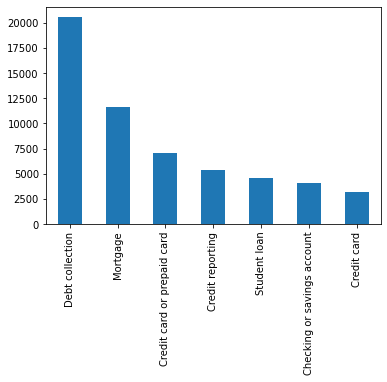

In [17]:
dataset.Product.value_counts().plot(kind='bar')

In [18]:
mapping = {}
for value in np.arange(len(np.unique(dataset.Product.values))):
    mapping[np.unique(dataset.Product.values)[value]] = value 

In [19]:
mapping

{'Checking or savings account': 0,
 'Credit card': 1,
 'Credit card or prepaid card': 2,
 'Credit reporting': 3,
 'Debt collection': 4,
 'Mortgage': 5,
 'Student loan': 6}

In [20]:
from sklearn.utils import shuffle
dataset['Target'] = dataset.Product.map(mapping)
dataset = shuffle(dataset)
dataset.head()

,Product,Complaint,Company,Target
1388651,Debt collection,I dispute all those bills because I 'm under X...,"Asset Management Outsourcing, Inc.",4
1401994,Mortgage,The following is a copy of complaint sent dire...,BANK OF THE WEST,5
1585619,Debt collection,Have sent them 3 certified letters to dispute ...,PORTFOLIO RECOVERY ASSOCIATES INC,4
1538986,Debt collection,I am filing a dispute because I received a let...,AES/PHEAA,4
1714227,Debt collection,My records associated with the account XXXX XX...,"Adler Wallach & Associates, Inc.",4


In [21]:
# Splitting data into train and test set
train, test = train_test_split(dataset, test_size=0.20, random_state=42)

In [22]:
print ('Shape of Train Data : {}'.format(train.shape))
print ('Shape of Test Data : {}'.format(test.shape))

Shape of Train Data : (45174, 4)
Shape of Test Data : (11294, 4)


In [23]:
pprint (train['Complaint'].values[10])

('A debt collector from XXXX contacted my husband and shared with him that he '
 'was attempting to collect a debt. Told him the amount of the debt. The call '
 'took place on Wednesday XXXX XXXX 2017 around XXXX XXXX EST. The debt '
 'collector never verified who it was that they were speaking with - never '
 'asked my husband to verify that he was myself. The debt collector just '
 'offered up my personal information.')


In [24]:
pprint (train['Complaint'].values[28])

("I hope you can help us, as we don't know where else to turn. We were given "
 'your name ( CFPB ) by XXXX XXXX XXXX and they advised us to contact you '
 'because of the trouble we are having with our current loan company and their '
 'unfair practices. \n'
 'We currently have a mortgage with Select Portfolio Servicing, SPS. Our '
 'current percentage rage is 8.85 %. We were looking into refinancing with '
 "XXXX XXXX XXXX and that's how we found our issues with SPS. There are 2 "
 'complaints I am filing against them today. \n'
 'SPS is stating we owe them {$9300.00} in escrow/delinquent taxes, from XXXX '
 'and XXXX. We never signed up for the escrow, as we pay our taxes outright '
 'every year. We paid the taxes in question and even have receipts for them. '
 'On XX/XX/XXXX, I filed a discrepency with SPS about the owed taxes and they '
 'said they would " have their team look into it. \'\' A few days later I got '
 'a phone call stating from SPS that they found no discrepency and

In [25]:
pprint (train['Complaint'].values[32])

('I closed a checking account from Chase bank in XX/XX/XXXX over the phone. '
 'They said they would mail me the remaining fund through a check. The check '
 'never arrived. I tried to resolve this over the phone, and visit the local '
 "bank branches many times. Now it's XX/XX/XXXX and I still haven't get my "
 'remaining fund.')


In [26]:
lemma = WordNetLemmatizer()

porter = nltk.PorterStemmer()

def clean_text(text):
    no_url_text = re.sub(r"http\S+", "", text)
    
    no_punct_text = re.sub("[^a-zA-Z#]", " ", no_url_text)
    
    no_num_text = re.sub("\d+{4-6}", " ", no_punct_text)

    no_encrypt_text = " ".join([word.strip('Xx/') for word in no_num_text.split()])
                               
    no_small_text = " ".join([word for word in no_encrypt_text.split() if len(word)>2])
    
    no_stop_text = " ".join([word for word in no_small_text.split() if word not in stopwords])
    
    # lemma_text = " ".join([lemma.lemmatize(word) for word in no_stop_text.split()])
    # stem_text = " ".join([porter.stem(word) for word in no_stop_text.split()])
    
    tokens = re.split('\W+', no_stop_text)
    return tokens

train['Complaint Tokens'] = train['Complaint'].apply(lambda x: clean_text(x.lower()))
train['Complaint Sentence'] = train['Complaint Tokens'].apply(lambda x: " ".join(x))
train.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Product,Complaint,Company,Target,Complaint Tokens,Complaint Sentence
571844,Credit card or prepaid card,Despite the required advance notice required b...,UNITED SERVICES AUTOMOBILE ASSOCIATION,2,"[despite, required, advance, notice, required,...",despite required advance notice required law c...
1686374,Debt collection,XXXX XXXX XXXX purchased {$600.00} medical bi...,"HCFS Health Care Financial Services, Inc.",4,"[purchased, medical, bill, originally, years, ...",purchased medical bill originally years old pa...
1298388,Debt collection,The XXXX department was paid after I had an au...,"Michael Harrison, Attorney at Law",4,"[department, paid, auto, accident, insurance, ...",department paid auto accident insurance pip co...
1565384,Credit card,In 2011 I hired XXXX XXXX as my caregiver foll...,DISCOVER BANK,1,"[hired, caregiver, followingsurgery, next, hal...",hired caregiver followingsurgery next half yea...
291441,Debt collection,I have this account in my credit report but is...,TOYOTA MOTOR CREDIT CORPORATION,4,"[account, credit, report, mine]",account credit report mine


In [26]:
x_train = train['Complaint Sentence']
y_train = train['Target']

x_test = test['Complaint']
y_test = test['Target']
x_train.head()

845664     multiple aggressive calls misrepresentation wr...
1339743    since around held bank america credit card pre...
1466426    first got letter credit protection association...
69174      called synchrony bank spoke several managers e...
1426183    client identity stolen result credit card open...
Name: Complaint Sentence, dtype: object

In [27]:
pprint (train['Complaint Sentence'].values[32])

('harvard collections collecting discharged debt listed case discharged state '
 'illinois also collecting barred accounts expired back taxes see attached '
 'going file class action effort soon')


In [28]:
pprint (train['Complaint Sentence'].values[28])

('owe credit card debt dispute debt collector handling debt presently '
 'portfolio recover associates llc complaint fraudulent use spoofing using '
 'technology allows portfolio recovery associates create fake caller numbers '
 'mislead calling cell phone latest number used phone cell others usa false '
 'caller numbers fraudulent representation regards calling portfolio recovery '
 'associates sincerely asked debt collecter list office branches one hung '
 'please leave personal information document remove legal record')


In [29]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=1000, ngram_range=(1,2))
x_train_vect = tfidf_vectorizer.fit_transform(x_train)
x_test_vect = tfidf_vectorizer.fit_transform(x_test)

In [30]:
df_train = pd.DataFrame(x_train_vect.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_train = pd.concat([df_train, train['Target'].reset_index(drop=True)], axis=1)

In [31]:
df_test = pd.DataFrame(x_test_vect.toarray(), columns=tfidf_vectorizer.get_feature_names())
df_test = pd.concat([df_test, test['Target'].reset_index(drop=True)], axis=1)

In [32]:
h2o_train_df = h2o.H2OFrame(df_train)
h2o_test_df = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
h2o_train_df['Target'] = h2o_train_df['Target'].asfactor()
h2o_test_df['Target'] = h2o_test_df['Target'].asfactor()

In [34]:
auto_ml = H2OAutoML(max_models=5, seed=10, exclude_algos=["StackedEnsemble"], verbosity="info", balance_classes=True, max_after_balance_size=0.30)

In [35]:
x = tfidf_vectorizer.get_feature_names()
y = 'Target'

In [ ]:
auto_ml.train(x=x, y=y, training_frame=h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
06:28:11.381: Project: AutoML_20200829_62811377
06:28:11.381: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
06:28:11.390: Setting stopping tolerance adaptively based on the training frame: 0.004706520789374209
06:28:11.390: Build control seed: 10
06:28:11.393: training frame: Frame key: automl_training_py_1_sid_af38    cols: 1001    rows: 45144  chunks: 52    size: 34328300  checksum: 2507625331485056931
06:28:11.398: validation frame: Frame key: py_2_sid_af38    cols: 1001    rows: 11287  chunks: 16    size: 17309963  checksum: 4967200347057232139
06:28:11.398: leaderboard frame: NULL
06:28:11.398: blending frame: NULL
06:28:11.398: response column: Target
06:28:11.398: fold column: null
06:28:11.398: weights column: null
06:28:11.426: Loading execution step

In [ ]:
auto_ml.leaderboard

In [ ]:
auto_ml.leader.predict(h2o_test_df)

In [ ]:
auto_ml.leader.model_performance(h2o_test_df)

In [ ]:
model_ids = list(auto_ml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [ ]:
model_out.convert_H2OXGBoostParams_2_XGBoostParams()

In [ ]:
import xgboost as XGB
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
xgb_clf = XGB.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, objective='multi:softprob', random_state=44)
xgb_clf.fit(x_train_vect, y_train)

In [ ]:
test_predictions = xgb_clf.predict(x_test_vect)

In [ ]:
cm = confusion_matrix(y_test, test_predictions)
print (cm)

In [ ]:
print (classification_report(y_test, test_predictions))

In [ ]:
from sklearn.utils import class_weight

class_weight = list(class_weight.compute_class_weight('balanced', np.unique(y_train), y_train))

In [ ]:
class_weight

In [ ]:
weights = np.ones(x_train.shape[0], dtype='float')

In [ ]:
for i, value in enumerate(y_train):
    weights[i] = class_weight[value]

In [ ]:
xgb_clf = XGB.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, objective='multi:softprob', random_state=44)
xgb_clf.fit(x_train_vect, y_train, sample_weight=weights)

In [ ]:
test_predictions = xgb_clf.predict(x_test_vect)
cm = confusion_matrix(y_test, test_predictions)
print (cm)

In [ ]:
print (classification_report(y_test, test_predictions))